In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 0)

import spacy

from pymystem3 import Mystem
m = Mystem()

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 
nltk.download('stopwords')

from imblearn.over_sampling import RandomOverSampler, SMOTE

import scipy.sparse

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams.update({'font.size': 17})

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/balyadavid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Функции для визуализации

In [2]:
def confusion_roc(model, features_train, features_test):
    model.fit(features_train, target_train)
    model_pred = model.predict(features_test)
    probabilities = model.predict_proba(features_test)[:,1]
    fpr, tpr, thresholds = roc_curve(target_test, probabilities)
    
    print('roc_auc:', round(roc_auc_score(target_test, model_pred), 4))
    print('f1_score:', round(f1_score(target_test, model_pred), 4))
    print('precision_score:', round(precision_score(target_test, model_pred), 4))
    print('recall_score:', round(recall_score(target_test, model_pred), 4))
    print('accuracy_score:', round(accuracy_score(target_test, model_pred), 4))
    
    plot_confusion_matrix(model, features_test, target_test, cmap='cividis', colorbar=False)
    plt.show()
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('True positive rate', fontsize = 18)
    plt.ylabel('False positive rate', fontsize = 18)
    plt.grid()
    
    
    plt.show()

In [3]:
res = pd.DataFrame(columns=['vectorizer', 'min_df', 'max_df', 'balanced', 'stem/lemm',
                              'roc_auc', 'f1', 'precision', 'recall', 'accuracy'])

In [4]:
def resres(model, features_train, features_test, vec, str_vec, str_oversampl, str_st_lm):
    res1 = vec.get_params()
    res2 = model.get_params()
    
    model.fit(features_train, target_train)
    model_pred = model.predict(features_test)
    
    roc_auc = roc_auc_score(target_test, model_pred)
    f1 = f1_score(target_test, model_pred)
    precision = precision_score(target_test, model_pred)
    recall = recall_score(target_test, model_pred)
    accuracy = accuracy_score(target_test, model_pred)
    
    return {'vectorizer' : str_vec, 'min_df': res1['min_df'], 'max_df': res1['max_df'],
                      'balanced': str_oversampl, 'stem/lemm':str_st_lm, 'roc_auc': roc_auc,
                      'f1': f1, 'precision' : precision, 'recall': recall, 'accuracy':accuracy}

In [5]:
df = pd.read_csv('labeled.csv')

In [6]:
features = df['comment']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=244466666)

## Baseline - TfidfVectorizer без настройки параметров + LR(class_weight='balanced')

In [7]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    tokens = word_tokenize(sentence_without_numbers, language="russian")
    return tokens

In [8]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence)
features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

In [9]:
lr_balanced_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

roc_auc: 0.8397
f1_score: 0.7875
precision_score: 0.7851
recall_score: 0.79
accuracy_score: 0.8557


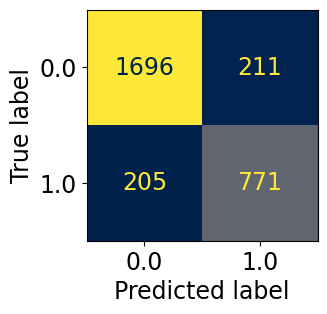

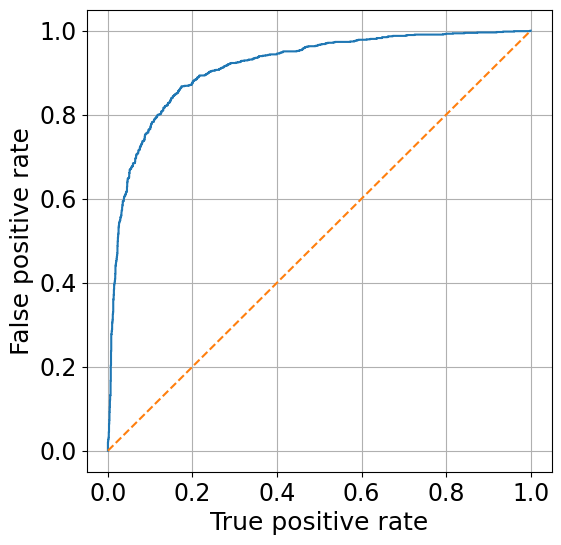

In [10]:
confusion_roc(lr_balanced_model, features_train_tf, features_test_tf)

In [11]:
balanced_model = resres(lr_balanced_model, features_train_tf, features_test_tf, count_tf_idf, 'Tfidf', 'balanced', '--')
res = res.append(balanced_model, ignore_index=True)

# Усложнение и интерпретация модели

Так как классы не сбалансированы, предлагается провести их балансировку, далее сравнить с результатами балансировки параметра class_weight='balanced' логистической регрессии.

## Оверсэмплинг 

### RandomOverSampler

In [12]:
ros = RandomOverSampler(random_state=244466666)

In [13]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence)
features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

In [14]:
features_train_resampled, target_train = ros.fit_resample(features_train_tf, target_train)

In [15]:
lr_oversampled_model = LogisticRegression(random_state = 244466666)

roc_auc: 0.8388
f1_score: 0.7885
precision_score: 0.8019
recall_score: 0.7756
accuracy_score: 0.8592


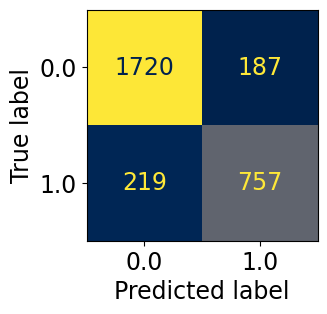

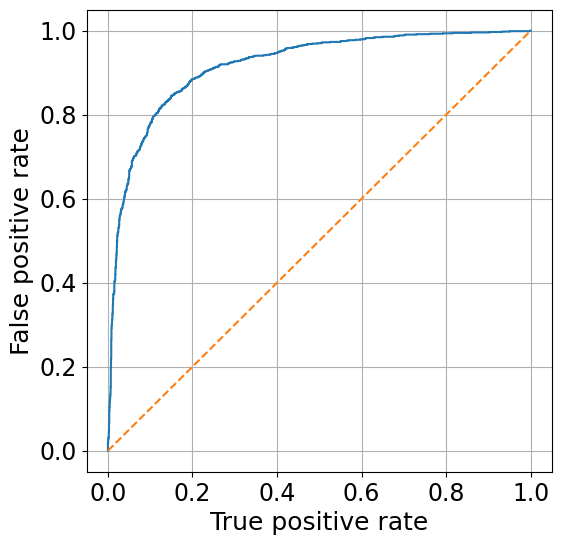

In [16]:
confusion_roc(lr_oversampled_model, features_train_resampled, features_test_tf)

In [17]:
oversampled_model = resres(lr_oversampled_model, features_train_resampled, features_test_tf, count_tf_idf, 'Tfidf', 'RandomOverSampler', 'pymystem3')
res = res.append(oversampled_model, ignore_index=True)

In [18]:
res

,vectorizer,min_df,max_df,balanced,stem/lemm,roc_auc,f1,precision,recall,accuracy
0,Tfidf,1,1.0,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
1,Tfidf,1,1.0,RandomOverSampler,pymystem3,0.838777,0.788542,0.801907,0.775615,0.859174


Результаты: балансировка классов не принесла значимых результатов. Предлагается оставить балансировку параметром class_weight='balanced' логистической регрессии.

## Сравнение стемминга и лемматизации для учучшения качесва классификации

### Только токенизация

In [19]:
df = pd.read_csv('labeled.csv')

In [20]:
features = df['comment']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=244466666)

In [21]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    tokens = word_tokenize(sentence_without_numbers, language="russian")
    return tokens

In [22]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence)
features_train_token = count_tf_idf.fit_transform(features_train)
features_test_token = count_tf_idf.transform(features_test)

In [23]:
lr_balanced_token_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

roc_auc: 0.8397
f1_score: 0.7875
precision_score: 0.7851
recall_score: 0.79
accuracy_score: 0.8557


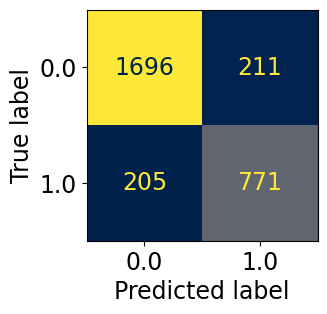

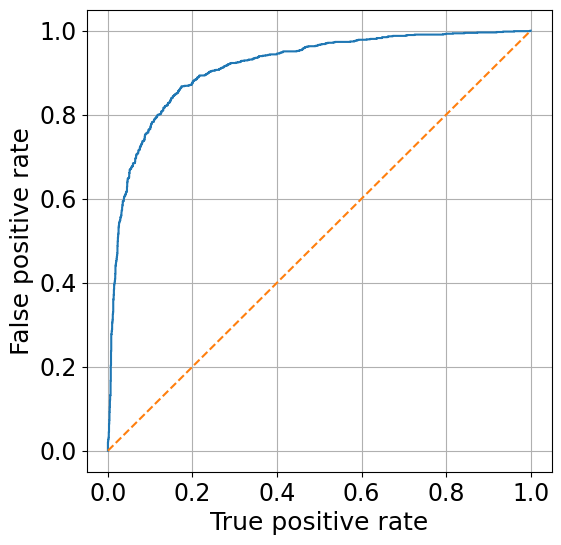

In [24]:
confusion_roc(lr_balanced_token_model, features_train_token, features_test_token)

In [25]:
balanced_token_model = resres(lr_balanced_token_model, features_train_token, features_test_token, count_tf_idf, 'Tfidf', 'balanced', '--')
res = res.append(balanced_token_model, ignore_index=True)

### Стемминг

In [26]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    tokens = word_tokenize(sentence_without_numbers, language="russian")
    stemmed=[stemmer.stem(word) for word in tokens]
    return stemmed

In [27]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence)
features_train_stem = count_tf_idf.fit_transform(features_train)
features_test_stem = count_tf_idf.transform(features_test)

In [28]:
lr_balanced_stem_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

roc_auc: 0.8767
f1_score: 0.8348
precision_score: 0.8235
recall_score: 0.8463
accuracy_score: 0.8866


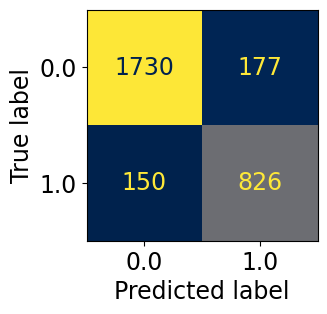

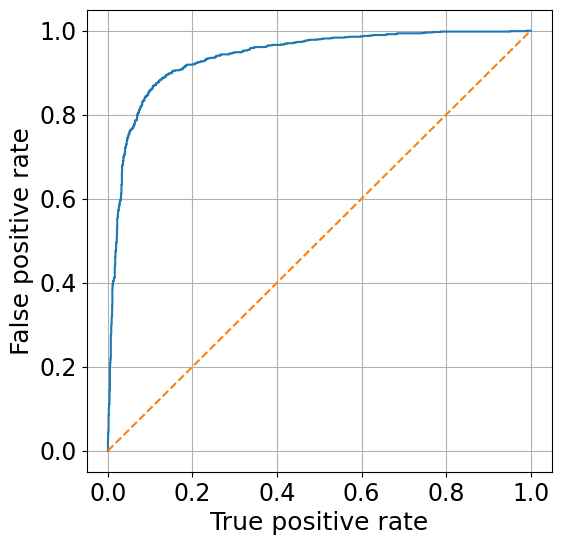

In [29]:
confusion_roc(lr_balanced_stem_model, features_train_stem, features_test_stem)

In [30]:
balanced_stem_model = resres(lr_balanced_stem_model, features_train_stem, features_test_stem, count_tf_idf, 'Tfidf', 'balanced', 'stemmer')
res = res.append(balanced_stem_model, ignore_index=True)

### Лемматизация pymystem3

In [31]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    lemmas = ''.join(m.lemmatize(sentence_without_numbers))
    tokens = word_tokenize(lemmas, language="russian")
    return tokens

In [32]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence)
features_train_pymystem3 = count_tf_idf.fit_transform(features_train)
features_test_pymystem3 = count_tf_idf.transform(features_test)

In [33]:
lr_balanced_pymystem3_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

roc_auc: 0.8768
f1_score: 0.835
precision_score: 0.825
recall_score: 0.8453
accuracy_score: 0.8869


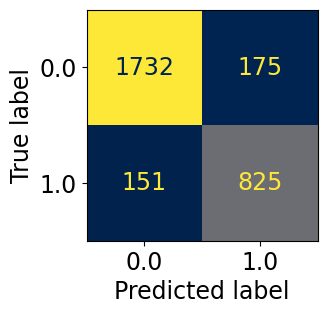

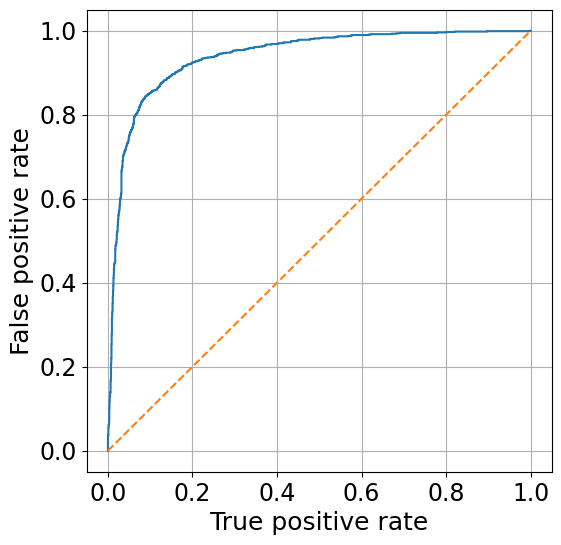

In [34]:
confusion_roc(lr_balanced_pymystem3_model, features_train_pymystem3, features_test_pymystem3)

In [35]:
balanced_pymystem3_model = resres(lr_balanced_pymystem3_model, features_train_pymystem3, features_test_pymystem3, count_tf_idf, 'Tfidf', 'balanced', 'pymystem3')
res = res.append(balanced_pymystem3_model, ignore_index=True)

### Лемматизация spacy

In [36]:
nlp = spacy.load("ru_core_news_sm")
tokenizer = nlp.tokenizer

In [37]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    doc = nlp(sentence_without_numbers)[:]
    lemmas = doc.lemma_
    tokens = word_tokenize(lemmas, language="russian")
    return tokens

In [38]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence)
features_train_spacy = count_tf_idf.fit_transform(features_train)
features_test_spacy = count_tf_idf.transform(features_test)

In [39]:
lr_balanced_spacy_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

roc_auc: 0.8651
f1_score: 0.8196
precision_score: 0.8086
recall_score: 0.8309
accuracy_score: 0.8762


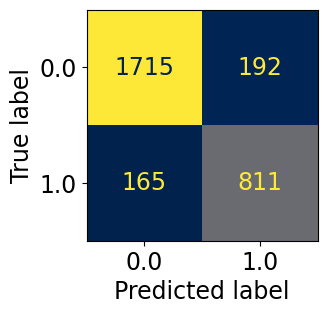

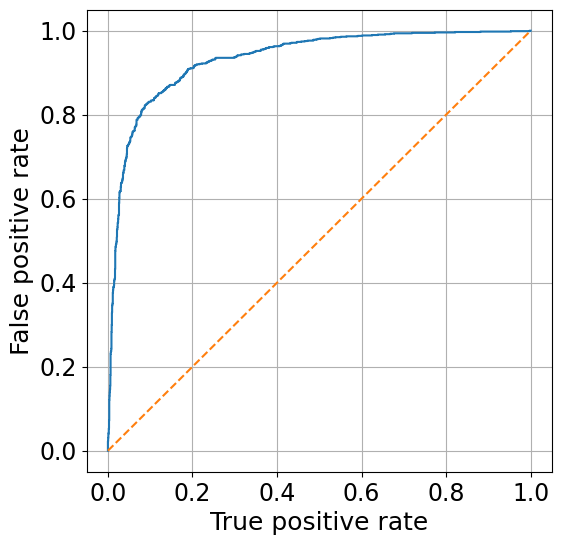

In [40]:
confusion_roc(lr_balanced_spacy_model, features_train_spacy, features_test_spacy)

In [41]:
balanced_spacy_model = resres(lr_balanced_spacy_model, features_train_spacy, features_test_spacy, count_tf_idf, 'Tfidf', 'balanced', 'spacy')
res = res.append(balanced_spacy_model, ignore_index=True)

In [42]:
res

,vectorizer,min_df,max_df,balanced,stem/lemm,roc_auc,f1,precision,recall,accuracy
0,Tfidf,1,1.0,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
1,Tfidf,1,1.0,RandomOverSampler,pymystem3,0.838777,0.788542,0.801907,0.775615,0.859174
2,Tfidf,1,1.0,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
3,Tfidf,1,1.0,balanced,stemmer,0.876748,0.834765,0.823529,0.846311,0.886576
4,Tfidf,1,1.0,balanced,pymystem3,0.876760,0.835020,0.825000,0.845287,0.886923
5,Tfidf,1,1.0,balanced,spacy,0.865130,0.819606,0.808574,0.830943,0.876171


## Настройка гиперпараметров векторайзера

In [43]:
df = pd.read_csv('labeled.csv')

In [44]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    lemmas = ''.join(m.lemmatize(sentence_without_numbers))
    tokens = word_tokenize(lemmas, language="russian")
    return tokens

In [45]:
features = df['comment']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=244466666)

In [46]:
def plot_cv_results(cv_results, param_x, metric='mean_test_score'):
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))
    sns.lineplot(x=col_x, y=metric, data=cv_results)
    ax.set_title("CV Grid Search Results", fontsize=14)
    ax.set_xlabel(param_x, fontsize=14)
    ax.set_ylabel('f1 score', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid()
    return fig

In [47]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_sentence)),
    ('lr_b', LogisticRegression(class_weight='balanced',random_state = 244466666))
     ])
parameters = {
    'tfidf__max_df': np.linspace(0.0001, 0.25, 25)
}

grid_search_tune0 = GridSearchCV(pipeline, parameters, cv=5, scoring='f1')
grid_search_tune0.fit(features_train, target_train)

print("Best parameters set:")
print(grid_search_tune0.best_estimator_.steps)

Best parameters set:
[('tfidf', TfidfVectorizer(max_df=0.12505,
                tokenizer=<function tokenize_sentence at 0x2cc1b6790>)), ('lr_b', LogisticRegression(class_weight='balanced', random_state=244466666))]


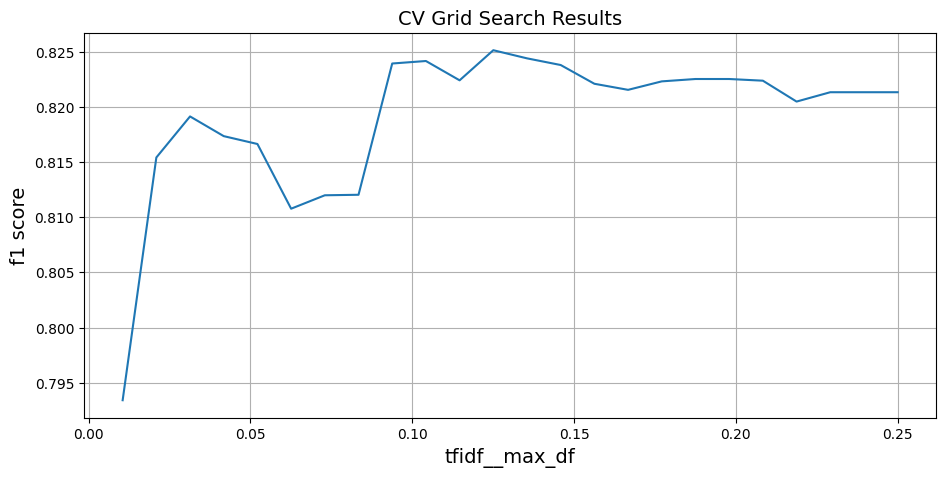

In [48]:
fig = plot_cv_results(grid_search_tune0.cv_results_, 'tfidf__max_df')

In [49]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_sentence)),
    ('lr_b', LogisticRegression(class_weight='balanced',random_state = 244466666))
     ])
parameters = {
    'tfidf__min_df': np.linspace(0.00001, 0.25, 25)
}

grid_search_tune2 = GridSearchCV(pipeline, parameters, cv=5, scoring='f1')
grid_search_tune2.fit(features_train, target_train)

print("Best parameters set:")
print(grid_search_tune2.best_estimator_.steps)

Best parameters set:
[('tfidf', TfidfVectorizer(min_df=1e-05,
                tokenizer=<function tokenize_sentence at 0x2cc1b6790>)), ('lr_b', LogisticRegression(class_weight='balanced', random_state=244466666))]


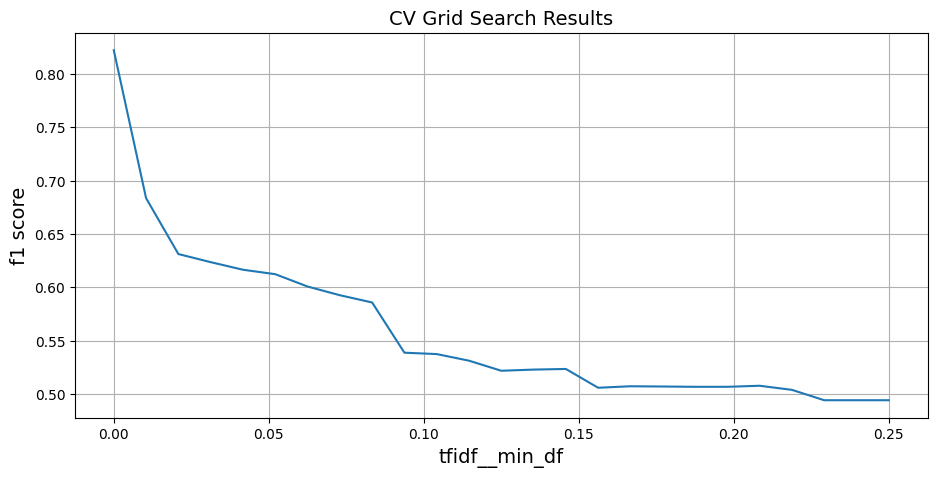

In [50]:
fig = plot_cv_results(grid_search_tune2.cv_results_, 'tfidf__min_df')

In [51]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_sentence)),
    ('lr_b', LogisticRegression(class_weight='balanced',random_state = 244466666))
     ])
parameters = {
    'tfidf__min_df': np.linspace(0.00001, 0.025, 10)
}

grid_search_tune3 = GridSearchCV(pipeline, parameters, cv=5, scoring='f1')
grid_search_tune3.fit(features_train, target_train)

print("Best parameters set:")
print(grid_search_tune3.best_estimator_.steps)

Best parameters set:
[('tfidf', TfidfVectorizer(min_df=1e-05,
                tokenizer=<function tokenize_sentence at 0x2cc1b6790>)), ('lr_b', LogisticRegression(class_weight='balanced', random_state=244466666))]


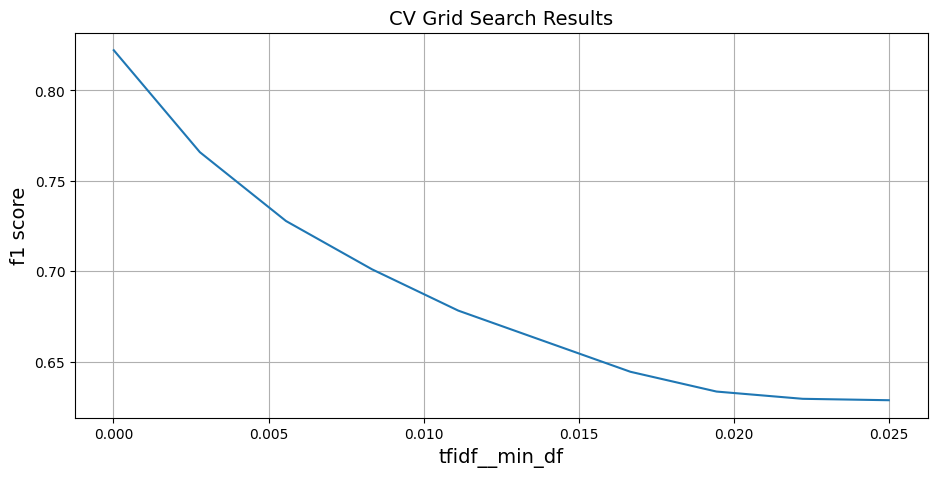

In [52]:
fig = plot_cv_results(grid_search_tune3.cv_results_, 'tfidf__min_df')

In [53]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_sentence)),
    ('lr_b', LogisticRegression(class_weight='balanced',random_state = 244466666))
     ])
parameters = {
    'tfidf__min_df': list(range(1, 21))
}

grid_search_tune4 = GridSearchCV(pipeline, parameters, cv=5, scoring='f1')
grid_search_tune4.fit(features_train, target_train)

print("Best parameters set:")
print(grid_search_tune4.best_estimator_.steps)

Best parameters set:
[('tfidf', TfidfVectorizer(min_df=2, tokenizer=<function tokenize_sentence at 0x2cc1b6790>)), ('lr_b', LogisticRegression(class_weight='balanced', random_state=244466666))]


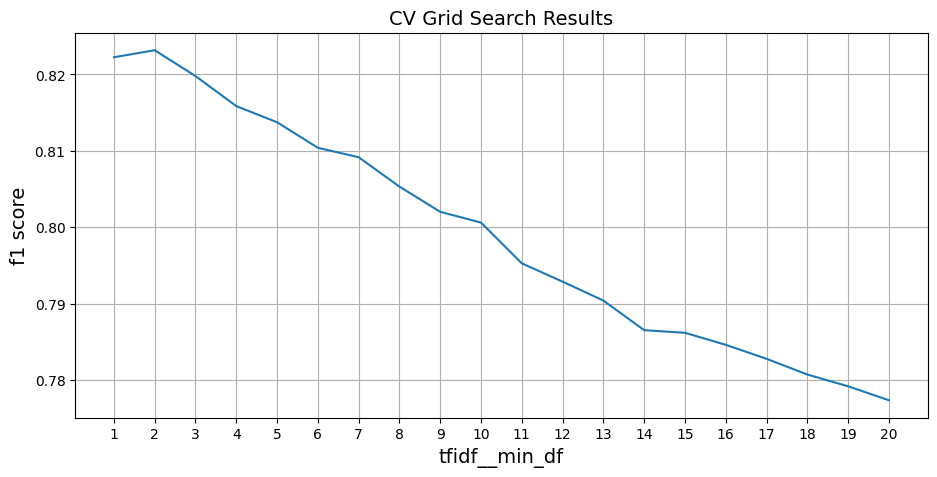

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
sns.lineplot(x='param_tfidf__min_df', y='mean_test_score', data=grid_search_tune4.cv_results_)
ax.set_title("CV Grid Search Results", fontsize=14)
ax.set_xlabel('tfidf__min_df', fontsize=14)
ax.set_ylabel('f1 score', fontsize=14)
ax.set_xticks(list(range(1, 21)))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()

## С настроенными параметрами:

In [55]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence, min_df=2, max_df=0.125)
features_train_min_max_tf = count_tf_idf.fit_transform(features_train)
features_test_min_max_tf = count_tf_idf.transform(features_test)

In [56]:
lr_balanced_min_max_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

roc_auc: 0.8739
f1_score: 0.8316
precision_score: 0.8233
recall_score: 0.8402
accuracy_score: 0.8848


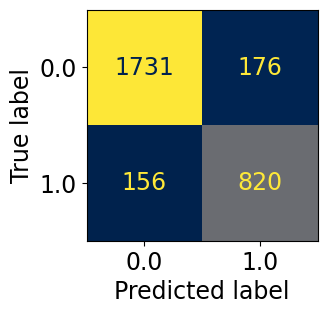

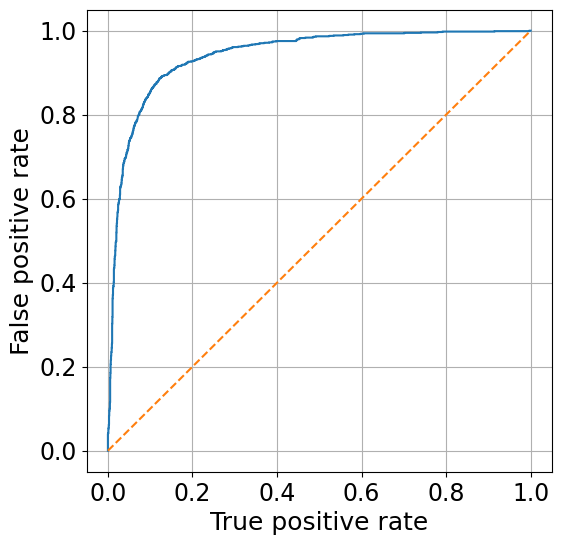

In [57]:
confusion_roc(lr_balanced_min_max_model, features_train_min_max_tf, features_test_min_max_tf)

In [58]:
min_max_model_1 = resres(lr_balanced_min_max_model, features_train_min_max_tf, features_test_min_max_tf, count_tf_idf, 'Tfidf', 'balanced', 'pymystem3')
res = res.append(min_max_model_1, ignore_index=True)

In [59]:
res

,vectorizer,min_df,max_df,balanced,stem/lemm,roc_auc,f1,precision,recall,accuracy
0,Tfidf,1,1.000,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
1,Tfidf,1,1.000,RandomOverSampler,pymystem3,0.838777,0.788542,0.801907,0.775615,0.859174
2,Tfidf,1,1.000,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
3,Tfidf,1,1.000,balanced,stemmer,0.876748,0.834765,0.823529,0.846311,0.886576
4,Tfidf,1,1.000,balanced,pymystem3,0.876760,0.835020,0.825000,0.845287,0.886923
5,Tfidf,1,1.000,balanced,spacy,0.865130,0.819606,0.808574,0.830943,0.876171
6,Tfidf,2,0.125,balanced,pymystem3,0.873936,0.831643,0.823293,0.840164,0.884842


По какой-то причине с параметрами векторайзера min_df=2, max_df=0.125, метрики оказались хуже, нежели без настройки параметров, в ходе ручного подбора гиперпараметров, удалось немного повысить качество классификации. 

Итоговые параметры векторайзера - min_df=1, max_df=0.2.

In [60]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence, min_df=1, max_df=0.2)
features_train_min_max_tf = count_tf_idf.fit_transform(features_train)
features_test_min_max_tf = count_tf_idf.transform(features_test)

In [61]:
lr_balanced_min_max_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

roc_auc: 0.8788
f1_score: 0.8376
precision_score: 0.8272
recall_score: 0.8484
accuracy_score: 0.8887


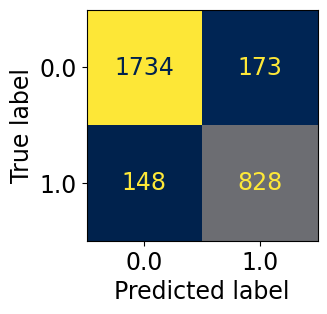

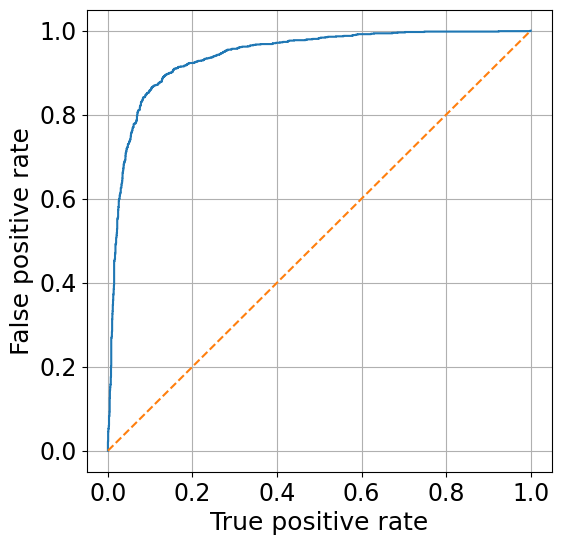

In [62]:
confusion_roc(lr_balanced_min_max_model, features_train_min_max_tf, features_test_min_max_tf)

In [65]:
min_max_model_2 = resres(lr_balanced_min_max_model, features_train_min_max_tf, features_test_min_max_tf, count_tf_idf, 'Tfidf', 'balanced', 'pymystem3')
res = res.append(min_max_model_2, ignore_index=True)

In [66]:
res

,vectorizer,min_df,max_df,balanced,stem/lemm,roc_auc,f1,precision,recall,accuracy
0,Tfidf,1,1.000,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
1,Tfidf,1,1.000,RandomOverSampler,pymystem3,0.838777,0.788542,0.801907,0.775615,0.859174
2,Tfidf,1,1.000,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
3,Tfidf,1,1.000,balanced,stemmer,0.876748,0.834765,0.823529,0.846311,0.886576
4,Tfidf,1,1.000,balanced,pymystem3,0.876760,0.835020,0.825000,0.845287,0.886923
5,Tfidf,1,1.000,balanced,spacy,0.865130,0.819606,0.808574,0.830943,0.876171
6,Tfidf,2,0.125,balanced,pymystem3,0.873936,0.831643,0.823293,0.840164,0.884842
7,Tfidf,1,0.200,balanced,pymystem3,0.878821,0.837633,0.827173,0.848361,0.888658


## Простая нейросеть

Также для решения задачи была применена простая полносвязная нейросеть, в качестве эксперимента.

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

from scikeras.wrappers import KerasClassifier

In [68]:
df = pd.read_csv('labeled.csv')

In [69]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    lemmas = ''.join(m.lemmatize(sentence_without_numbers))
    tokens = word_tokenize(lemmas, language="russian")
    return tokens

In [70]:
features = df['comment']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=244466666)

In [71]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence, min_df=1, max_df=1.0)
features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

In [72]:
features_train_tf.shape[1]

28854

In [73]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(features_train_tf.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

In [74]:
model.compile(loss='binary_crossentropy', optimizer='Adam',
             metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3693440   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,693,569
Trainable params: 3,693,569
Non-trainable params: 0
_________________________________________________________________


In [76]:
features_train_tf_1 = pd.DataFrame.sparse.from_spmatrix(features_train_tf, columns=count_tf_idf.get_feature_names()).iloc[:,:].values
features_test_tf_1 = pd.DataFrame.sparse.from_spmatrix(features_test_tf, columns=count_tf_idf.get_feature_names()).iloc[:,:].values
features_train_tf_1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
history = model.fit(features_train_tf_1, target_train, batch_size=128, epochs=2)

Epoch 1/2


2023-02-07 16:21:29.787303: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


91/91 [==============================] - 1s 12ms/step - loss: 0.5482 - precision: 0.8982 - recall: 0.1582
Epoch 2/2
91/91 [==============================] - 1s 12ms/step - loss: 0.2832 - precision: 0.9309 - recall: 0.8262


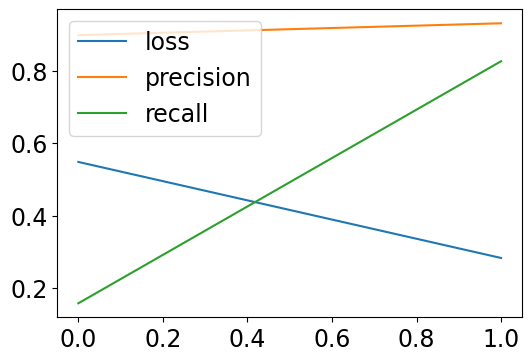

In [78]:
pd.DataFrame(history.history).plot(figsize=(6,4))
plt.show()

In [79]:
Y_test = model.predict(features_test_tf_1)
Y_test

91/91 [==============================] - 0s 2ms/step


array([[0.83549464],
       [0.05329828],
       [0.35708776],
       ...,
       [0.29654378],
       [0.5523856 ],
       [0.17370653]], dtype=float32)

In [80]:
y_classes = ((Y_test > 0.5)+0).ravel()
y_classes

array([1, 0, 0, ..., 0, 1, 0])

roc_auc: 0.8669
f1_score: 0.8314
precision_score: 0.8763
recall_score: 0.791
accuracy_score: 0.8914


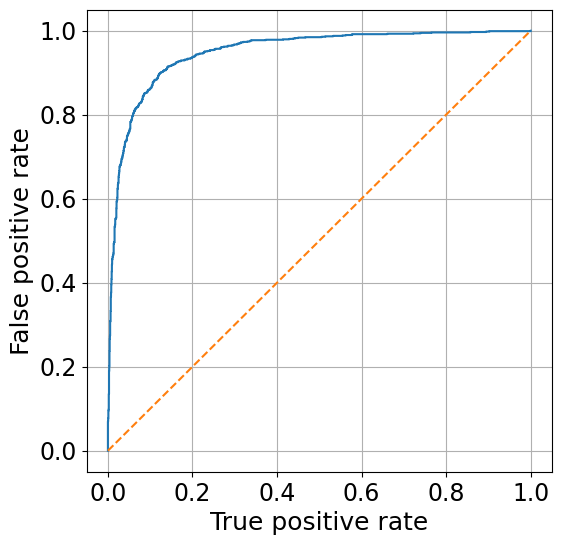

In [81]:
model_pred = y_classes
probabilities = Y_test
fpr, tpr, thresholds = roc_curve(target_test, probabilities)
    
print('roc_auc:', round(roc_auc_score(target_test, model_pred), 4))
print('f1_score:', round(f1_score(target_test, model_pred), 4))
print('precision_score:', round(precision_score(target_test, model_pred), 4))
print('recall_score:', round(recall_score(target_test, model_pred), 4))
print('accuracy_score:', round(accuracy_score(target_test, model_pred), 4))

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('True positive rate', fontsize = 18)
plt.ylabel('False positive rate', fontsize = 18)
plt.grid()
    
plt.show()

In [82]:
confusion_matrix(target_test, y_classes)

array([[1798,  109],
       [ 204,  772]])

In [83]:
model_pred = y_classes
probabilities = Y_test

res = res.append({'vectorizer' : 'Tfidf', 'min_df': 1, 'max_df': 1.0,
                  'balanced': '- -', 'stem/lemm': 'pymystem3', 'roc_auc': round(roc_auc_score(target_test, model_pred), 4),
                  'f1': round(f1_score(target_test, model_pred), 4), 'precision' : round(precision_score(target_test, model_pred), 4), 
                  'recall': round(recall_score(target_test, model_pred), 4), 'accuracy': round(accuracy_score(target_test, model_pred), 4)}, ignore_index=True)

In [84]:
res

,vectorizer,min_df,max_df,balanced,stem/lemm,roc_auc,f1,precision,recall,accuracy
0,Tfidf,1,1.000,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
1,Tfidf,1,1.000,RandomOverSampler,pymystem3,0.838777,0.788542,0.801907,0.775615,0.859174
2,Tfidf,1,1.000,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706
3,Tfidf,1,1.000,balanced,stemmer,0.876748,0.834765,0.823529,0.846311,0.886576
4,Tfidf,1,1.000,balanced,pymystem3,0.876760,0.835020,0.825000,0.845287,0.886923
5,Tfidf,1,1.000,balanced,spacy,0.865130,0.819606,0.808574,0.830943,0.876171
6,Tfidf,2,0.125,balanced,pymystem3,0.873936,0.831643,0.823293,0.840164,0.884842
7,Tfidf,1,0.200,balanced,pymystem3,0.878821,0.837633,0.827173,0.848361,0.888658
8,Tfidf,1,1.000,- -,pymystem3,0.866900,0.831400,0.876300,0.791000,0.891400


## Выводы

В ходе работы решалась задача классификации токсичности комментариев. Для решения этой задачи была применена логистическая регрессия, предварительно была проведена предобработка и векторизация текста.

Можно говорить о том, что полученная модель обладает дочтаточным качеством классификации (87.88%). В рамках дальнейшей работы предлагается использование нейросетей для данной задачи.